In [2]:
import sys
sys.path.append('../../')
import RdPCA.src.model as rdpca

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt

from scipy.io import mmread
from openTSNE import TSNE

In [2]:
exp_data = mmread('../data/pbmc_covid19/matrix.mtx').toarray().astype(float)
exp_data_col = pd.read_csv('../data/pbmc_covid19/barcodes.tsv')['x']
exp_data_row = pd.read_csv('../data/pbmc_covid19/features.tsv')['x']
hvg = pd.read_csv('../data/pbmc_covid19/hvg.vst.tsv')['x'].values
exp_data_meta = pd.read_csv('../data/pbmc_covid19/meta.csv', index_col=0)
size_factor = exp_data_meta['nCount_RNA']/exp_data_meta['nCount_RNA'].mean()

In [3]:
device_cuda_list = [torch.device("cuda:{}".format(i)) for i in range(6)[::-1]]
torch.set_default_tensor_type(torch.FloatTensor)
dtype = torch.float32
data = pd.DataFrame(exp_data, columns=exp_data_col, index=exp_data_row)
expr_mat = torch.tensor(data.T.loc[:,hvg[:3000]].values, dtype=dtype)
cc_mat = torch.tensor(exp_data_meta.loc[:,['S.Score', 'G2M.Score']].values, dtype=dtype)
sf = torch.tensor(size_factor, dtype=dtype)
batch_mat = torch.tensor(pd.get_dummies(exp_data_meta.loc[:,'Donor'], drop_first=True).values, dtype=dtype)
device = device_cuda_list[3]

In [4]:
import imp
imp.reload(rdpca)
torch.manual_seed(0)
n_lat = 40
red = rdpca.fit_pca_linear(expr_mat, n_lat, cc_mat, sf, batch_mat, device=device)

step 0: loss -487.95
step 50: loss -1563.68
step 100: loss -1604.68
step 150: loss -1612.88
step 200: loss -1615.56
step 250: loss -1617.01
step 300: loss -1617.63


In [5]:
np.savetxt('rdpca.csv', red.detach().cpu().numpy(), delimiter=',')

# RdPCA

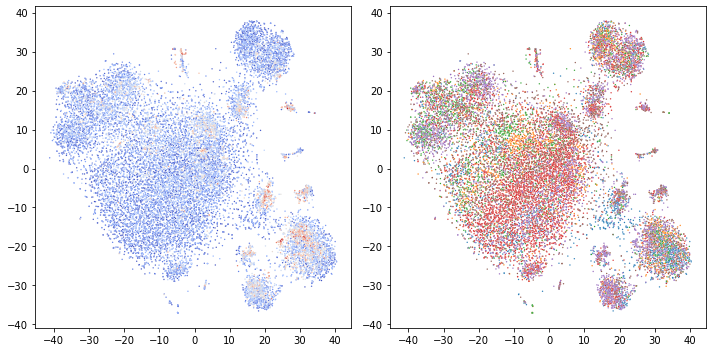

In [6]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(red.detach().cpu().numpy())

fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2,
               ax=ax[0])
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=exp_data_meta.Donor, legend=False,
                s=2,
               ax=ax[1])
plt.tight_layout()

In [8]:
pd.DataFrame(tsne2, columns=['tSNE_1', 'tSNE_2']).to_csv('tsne_rdpca.csv')

# PCA

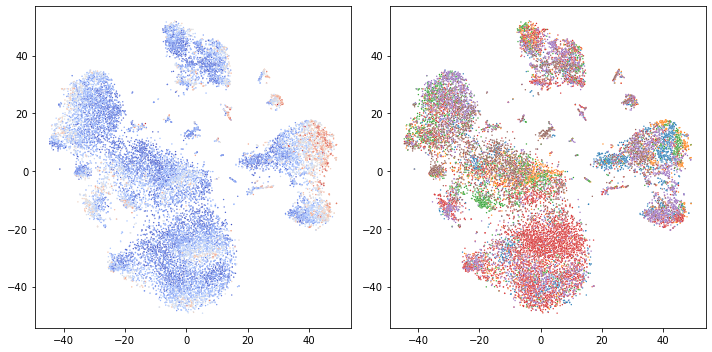

In [6]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('pca.csv', index_col=0).iloc[:,:40].values)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2,
               ax=ax[0])
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=exp_data_meta.Donor, legend=False,
                s=2,
               ax=ax[1])
plt.tight_layout()

# SCT

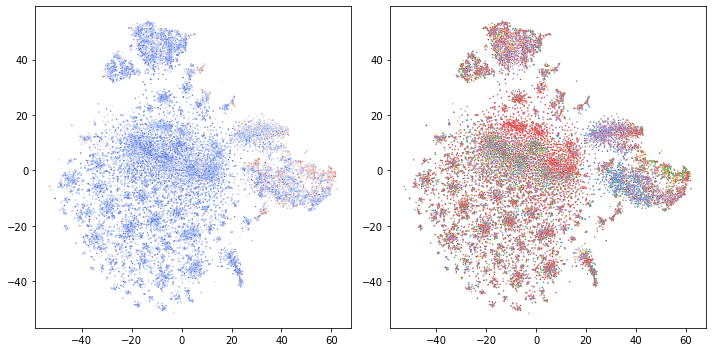

In [9]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=12, perplexity=70).fit(pd.read_csv('sct.csv', index_col=0).iloc[:,:40].values)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2,
               ax=ax[0])
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=exp_data_meta.Donor, legend=False,
                s=2,
               ax=ax[1])
plt.tight_layout()

In [10]:
pd.DataFrame(tsne2, columns=['tSNE_1', 'tSNE_2']).to_csv('tsne_sct.csv')

# GLM-PCA

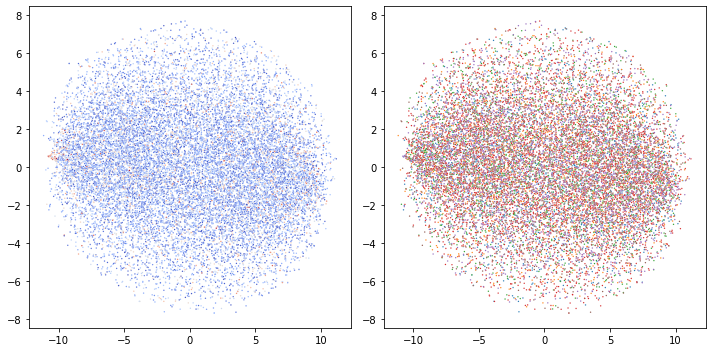

In [7]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('glmpca.csv', index_col=0).iloc[:,:40].values)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2,
               ax=ax[0])
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=exp_data_meta.Donor, legend=False,
                s=2,
               ax=ax[1])
plt.tight_layout()

# Expr

In [14]:
data.loc[['FCGR3A', 'CD14', 'ETS1', 'TRBC2', 'CD3D', 'PTPRCAP', 'PRF1', 'SLC38A1'],:].to_csv('exprs.csv')

# Doublet

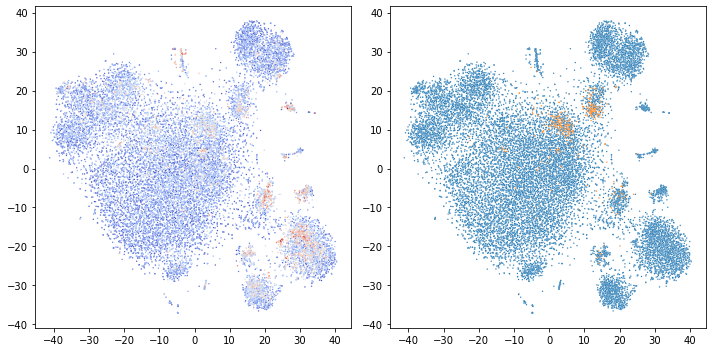

In [7]:
np.random.seed(0)
#tsne2 = TSNE(n_jobs=4, perplexity=70).fit(red.detach().cpu().numpy())

fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2,
               ax=ax[0])
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=pd.read_csv('doublet.csv', index_col=0)['DF.classifications_0.25_0.005_499'], legend=False,
                s=2,
               ax=ax[1])
plt.tight_layout()

# Supp figure 5

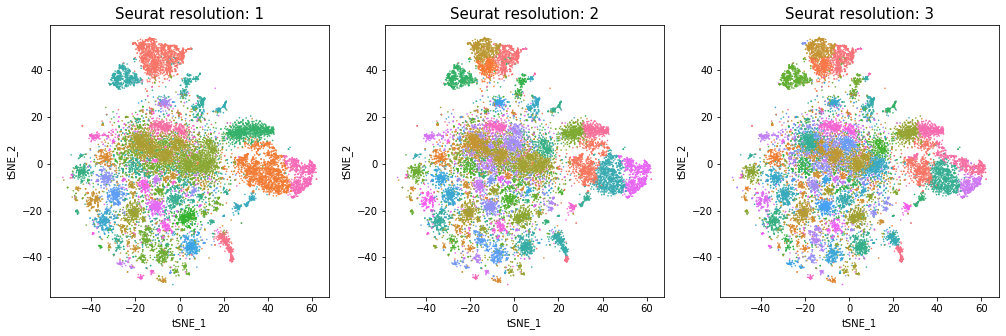

In [17]:
fig, ax = plt.subplots(1,3,figsize=(17, 5))
tsne = pd.read_csv('tsne_sct.csv', index_col=0)
for i in range(3):
    meta = pd.read_csv('meta_sct_%s.csv'%(i+1), index_col=0)
    sns.scatterplot(x='tSNE_1', y='tSNE_2', data=tsne, ax=ax[i], s=2, edgecolor=None, hue=meta['seurat_clusters'].values.astype(str),
                   legend=False)
    ax[i].set_title('Seurat resolution: %s' % (i+1), fontsize=15)